<a href="https://colab.research.google.com/github/Savith-02/notebooks/blob/main/rnn_intent_classifier/rnn_intent_classifier_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
def read_dataset(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            intent, sentence = line.strip().split(',')
            data.append((intent.strip(), sentence.strip()))
    return data

# Example usage
file_path = "drive/MyDrive/Code/rawData/data.txt"  # Replace with the path to your dataset file
dataset = read_dataset(file_path)[1:]
print(dataset[:10])

[('Greet', 'Hi'), ('Greet', 'Hello'), ('Greet', 'Hey there'), ('Greet', 'Good morning'), ('Greet', 'Howdy'), ('Greet', 'Hi there'), ('Greet', 'Hey'), ('Greet', 'Good afternoon'), ('Greet', 'Hello there'), ('Greet', 'Hi how can I help you?')]


In [10]:
split = round(len(dataset) * 60 / 100)
training_data = dataset[:split]
cv_data = dataset[split:]

In [11]:
intent_counts = {}
for intent, _ in dataset:
    if intent not in intent_counts:
        intent_counts[intent] = 0
    intent_counts[intent] += 1
print(intent_counts)

{'Greet': 28, 'Farewell': 25, 'Inquiry': 26, 'Feedback': 98, 'Complaint': 68, 'Request': 50, 'Navigation': 58, 'Confirmation': 58}


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim as optim


# Define the vocabulary
all_chars = set(''.join([sentence for intent, sentence in dataset]))
char_to_index = {char: i for i, char in enumerate(all_chars)}
index_to_char = {i: char for char, i in char_to_index.items()}
num_chars = len(all_chars)

all_intents = set(intent for intent, _ in dataset[1:])
intent_to_index = {intent: i for i, intent in enumerate(all_intents)}
index_to_intent = {i: intent for intent, i in intent_to_index.items()}
num_intents = len(all_intents)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert sentences to tensors
def sentence_to_tensor(sentence):
    tensor = torch.zeros(len(sentence), 1, num_chars).to(device)
    for i, char in enumerate(sentence):
        tensor[i][0][char_to_index[char]] = 1
    return tensor

# Convert intents to tensors
def intent_to_tensor(intent):
    return torch.tensor([intent_to_index[intent]], dtype=torch.long).to(device)

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        hidden = self.init_hidden()
        output, _ = self.rnn(input, hidden)
        output = self.fc(output[-1])
        output = self.softmax(output)
        return output

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device)

In [13]:
print(all_intents)
print(intent_to_index)

{'Complaint', 'Feedback', 'Farewell', 'Confirmation', 'Inquiry', 'Request', 'Navigation', 'Greet'}
{'Complaint': 0, 'Feedback': 1, 'Farewell': 2, 'Confirmation': 3, 'Inquiry': 4, 'Request': 5, 'Navigation': 6, 'Greet': 7}


In [14]:
# # Define hyperparameters
# hidden_size = 128
# learning_rate = 0.001
# epochs = 100

# # Initialize the model
# model = RNN(num_chars, hidden_size, num_intents)
# model.to(device)

# loss_function = nn.NLLLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# # Training loop with loss plotting
# losses = []
# for epoch in range(epochs):
#     total_loss = 0
#     for intent, sentence in dataset:
#         model.zero_grad()
#         intent_tensor = intent_to_tensor(intent)
#         sentence_tensor = sentence_to_tensor(sentence)
#         output = model(sentence_tensor)
#         loss = loss_function(output, intent_tensor)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     scheduler.step()
#     losses.append(total_loss)
#     if (epoch + 1) % 10 == 0:
#         print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

# # Plot the loss
# plt.plot(losses)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.show()


In [15]:

def train_rnn(model, training_data, cv_data, intent_to_tensor, sentence_to_tensor, device, hidden_size, learning_rate, epochs):

    # Initialize the model
    model = model(num_chars, hidden_size, num_intents)
    model.to(device)

    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    # Training loop with loss plotting
    losses = []
    cv_losses = []
    training_dataset_len = len(training_data)
    cv_dataset_len = len(cv_data)

    for epoch in range(epochs):
        total_loss = 0

        for intent, sentence in training_data:
            model.zero_grad()
            intent_tensor = intent_to_tensor(intent)
            sentence_tensor = sentence_to_tensor(sentence)
            output = model(sentence_tensor)
            loss = loss_function(output, intent_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        # losses.append(total_loss / training_dataset_len)
        losses.append(total_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

        total_cv_loss = 0
        with torch.no_grad():
          for intent, sentence in cv_data:
              intent_tensor = intent_to_tensor(intent)
              sentence_tensor = sentence_to_tensor(sentence)
              output = model(sentence_tensor)
              loss = loss_function(output, intent_tensor)
              total_cv_loss += loss.item()

          cv_losses.append(total_cv_loss)

    return losses, cv_losses, model

In [16]:
# losses_container = []
# learning_rates = [0.001, 0.003, 0.01, 0.03, 0.1]
# num = len(learning_rates)


# for i in range(num):
#   loss_arr, cv_loss_arr = train_rnn(
#     model=RNN,
#     training_data=training_data,
#     cv_data=cv_data,
#     intent_to_tensor=intent_to_tensor,
#     sentence_to_tensor=sentence_to_tensor,
#     device=device,
#     hidden_size=128,
#     learning_rate=learning_rates[i],
#     epochs=100
#   )
#   losses_container.append([loss_arr, cv_loss_arr])


In [17]:
# len(losses_container)

In [18]:
# fig, ax = plt.subplots(2, 3, figsize=(18, 10))
# fig.suptitle('Training Loss for Different Learning Rates', fontsize=16)

# for i in range(2):
#     for j in range(3):
#       if i == 1 and j == 2:
#         continue
#       ax[i][j].plot(losses_container[i * 3 + j][0], label='Training Loss', color='b')
#       ax[i][j].plot(losses_container[i * 3 + j][1], label='CV Loss', color='r')
#       ax[i][j].set_title(f'Learning Rate: {learning_rates[i * 3 + j]}', fontsize=12, fontweight='bold')
#       ax[i][j].set_xlabel('Epochs')
#       ax[i][j].set_ylabel('Loss')
#       ax[i][j].legend()

# plt.subplots_adjust(wspace=0.5, hspace=0.5)
# plt.show()

In [19]:
# Test the model
# def predict_intent(sentence):
#     with torch.no_grad():
#         output = model(sentence_to_tensor(sentence))
#         _, predicted_index = torch.max(output, 1)
#         predicted_intent = index_to_intent[predicted_index.item()]
#         return predicted_intent

# # Example usage
# test_sentence = "How are you?"
# print("Predicted intent:", predict_intent(test_sentence))

In [20]:
# all_intents

In [21]:
# char_to_index.items()

In [22]:
# loss_arr, cv_arr = train_rnn(
#     model=RNN,
#     training_data=training_data,
#     cv_data=cv_data,
#     intent_to_tensor=intent_to_tensor,
#     sentence_to_tensor=sentence_to_tensor,
#     device=device,
#     hidden_size=254,
#     learning_rate=0.0001,
#     epochs=100
#   )

In [23]:
# plt.figure(figsize=(4, 4))
# plt.plot(loss_arr)
# plt.plot(cv_arr)
# plt.show()

In [24]:
class RNN_regularised(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, l2_reg=0.001):
        super(RNN_regularised, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.l2_reg = l2_reg

    def forward(self, input):
        hidden = self.init_hidden()
        output, _ = self.rnn(input, hidden)
        output = self.fc(output[-1])
        output = self.softmax(output)
        return output

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device)


In [144]:
import numpy as np
import random

def train_rnn_regularised(model, training_data, cv_data, intent_to_tensor, sentence_to_tensor, device, hidden_size, learning_rate, epochs, l2_reg):

    # Initialize the model
    model = model(num_chars, hidden_size, num_intents, l2_reg)
    model.to(device)

    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=model.l2_reg)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    # Training loop with loss plotting
    losses = []
    cv_losses = []
    training_dataset_len = len(training_data)
    cv_dataset_len = len(cv_data)
    prediction_accuracy = np.zeros((len(all_intents), 2))

    for epoch in range(epochs):
        total_loss = 0
        training_data = random.sample(training_data, k=len(training_data))

        for intent, sentence in training_data:
            model.zero_grad()
            intent_tensor = intent_to_tensor(intent)
            sentence_tensor = sentence_to_tensor(sentence)
            output = model(sentence_tensor)

            prediction_accuracy[intent_tensor][0] += 1 #[torch.argmax(output)]
            if torch.argmax(output) == intent_tensor:
              prediction_accuracy[intent_tensor][1] += 1

            loss = loss_function(output, intent_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        losses.append(total_loss / training_dataset_len )
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / training_dataset_len}")

        rounded_ratios = np.round(prediction_accuracy[:, 1] / prediction_accuracy[:, 0], 3)
        # print(f"epoch {epoch}: \n{prediction_accuracy}")
        print(f"epoch {epoch}: probability: {rounded_ratios} %")

        total_cv_loss = 0
        with torch.no_grad():
          for intent, sentence in cv_data:
              intent_tensor = intent_to_tensor(intent)
              sentence_tensor = sentence_to_tensor(sentence)
              output = model(sentence_tensor)
              loss = loss_function(output, intent_tensor)
              total_cv_loss += loss.item()

          cv_losses.append(total_cv_loss / cv_dataset_len )

    return losses, cv_losses, model, prediction_accuracy

In [138]:
train_losses_container_reg = []
cv_losses_container_reg = []
reg_rates = [0.001, 0.005, 0.008, 0.01, 0.13]

for i in range(len(reg_rates)):
  loss_arr, cv_loss_arr, model, prediction_accuracy = train_rnn_regularised(
      model=RNN_regularised,
      training_data=training_data,
      cv_data=cv_data,
      intent_to_tensor=intent_to_tensor,
      sentence_to_tensor=sentence_to_tensor,
      device=device,
      hidden_size=350,
      learning_rate=0.0001,
      epochs=30,
      l2_reg=reg_rates[i]
    )

  train_losses_container_reg.append(loss_arr)
  cv_losses_container_reg.append(cv_loss_arr)


epoch 0: 
[[20.  0.]
 [69. 60.]
 [25.  0.]
 [29.  2.]
 [26.  0.]
 [21.  0.]
 [29.  0.]
 [28.  0.]] - probability: [[0.   ]
 [0.87 ]
 [0.   ]
 [0.069]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]] %
epoch 1: 
[[ 40.   0.]
 [138. 129.]
 [ 50.   0.]
 [ 58.   2.]
 [ 52.   0.]
 [ 42.   0.]
 [ 58.   0.]
 [ 56.   0.]] - probability: [[0.   ]
 [0.935]
 [0.   ]
 [0.034]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]] %
epoch 2: 
[[ 60.   0.]
 [207. 194.]
 [ 75.   4.]
 [ 87.   2.]
 [ 78.   0.]
 [ 63.   0.]
 [ 87.   0.]
 [ 84.   0.]] - probability: [[0.   ]
 [0.937]
 [0.053]
 [0.023]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]] %
epoch 3: 
[[ 80.   0.]
 [276. 263.]
 [100.   8.]
 [116.   2.]
 [104.   4.]
 [ 84.   0.]
 [116.   3.]
 [112.   4.]] - probability: [[0.   ]
 [0.953]
 [0.08 ]
 [0.017]
 [0.038]
 [0.   ]
 [0.026]
 [0.036]] %
epoch 4: 
[[100.   0.]
 [345. 332.]
 [125.  14.]
 [145.   2.]
 [130.  10.]
 [105.   0.]
 [145.  14.]
 [140.  10.]] - probability: [[0.   ]
 [0.962]
 [0.112]
 [0.014]
 [0.077]
 [0.   ]
 [0.097]
 [0

In [140]:
column = 4
diagram_count = len(train_losses_container_reg)
row = int(np.ceil(diagram_count / column))
print(column, row, diagram_count)

4 2 5


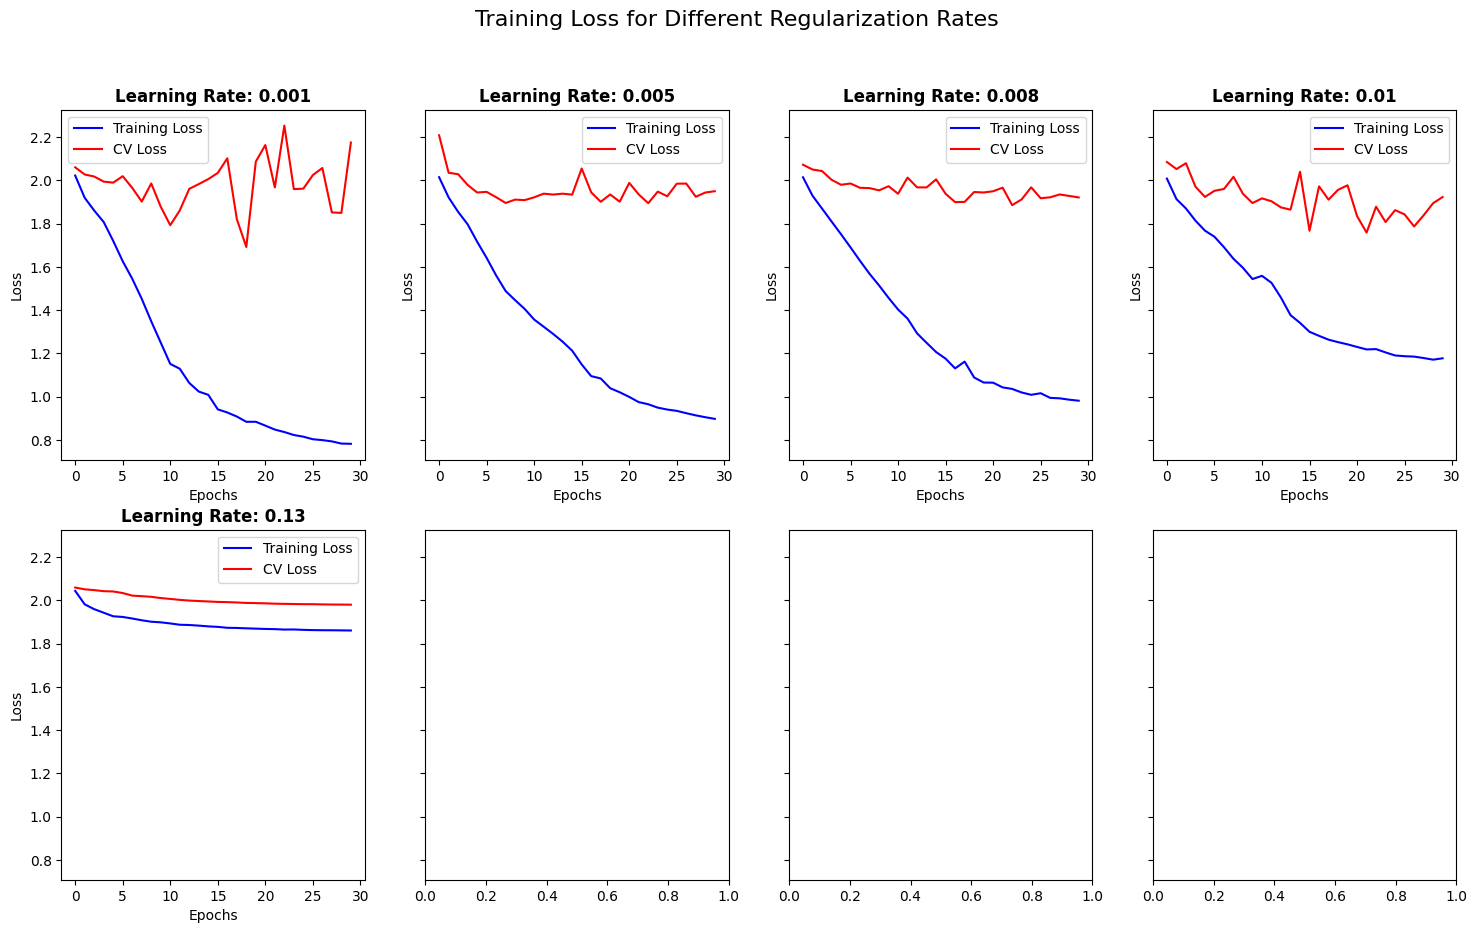

In [141]:
fig, ax = plt.subplots(row, column, figsize=(18, 10), sharey=True)
fig.suptitle('Training Loss for Different Regularization Rates - hidden units: 350', fontsize=16)

for i in range(row):
    for j in range(column):
      # print(i * column + j)
      if i * column + j > diagram_count - 1:
        continue
      ax[i][j].plot(train_losses_container_reg[i * column + j], label='Training Loss', color='b')
      ax[i][j].plot(cv_losses_container_reg[i * column + j], label='CV Loss', color='r')
      ax[i][j].set_title(f'Regularization Rate: {reg_rates[i * column + j]}', fontsize=12, fontweight='bold')
      ax[i][j].set_xlabel('Epochs')
      ax[i][j].set_ylabel('Loss')
      ax[i][j].legend()


plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

In [145]:
train_losses_container_reg = []
cv_losses_container_reg = []
reg_rates = [0.001, 0.005, 0.01, 0.015]

for i in range(len(reg_rates)):
  loss_arr, cv_loss_arr, model, prediction_accuracy = train_rnn_regularised(
      model=RNN_regularised,
      training_data=training_data,
      cv_data=cv_data,
      intent_to_tensor=intent_to_tensor,
      sentence_to_tensor=sentence_to_tensor,
      device=device,
      hidden_size=124,
      learning_rate=0.0001,
      epochs=30,
      l2_reg=reg_rates[i]
    )

  train_losses_container_reg.append(loss_arr)
  cv_losses_container_reg.append(cv_loss_arr)


epoch 0: probability: [0.    0.638 0.    0.    0.    0.    0.31  0.   ] %
epoch 1: probability: [0.    0.819 0.    0.    0.    0.    0.155 0.   ] %
epoch 2: probability: [0.    0.879 0.    0.    0.    0.    0.103 0.   ] %
epoch 3: probability: [0.    0.909 0.    0.    0.    0.    0.078 0.   ] %
epoch 4: probability: [0.    0.928 0.    0.    0.    0.    0.062 0.   ] %
epoch 5: probability: [0.    0.94  0.    0.    0.    0.    0.052 0.   ] %
epoch 6: probability: [0.    0.946 0.023 0.    0.    0.    0.049 0.061] %
epoch 7: probability: [0.    0.951 0.04  0.    0.01  0.    0.043 0.138] %
epoch 8: probability: [0.    0.952 0.053 0.004 0.03  0.    0.054 0.23 ] %
Epoch 10/30, Loss: 1.6087191909672278
epoch 9: probability: [0.    0.955 0.064 0.003 0.042 0.    0.059 0.293] %
epoch 10: probability: [0.    0.959 0.073 0.003 0.052 0.    0.066 0.338] %
epoch 11: probability: [0.    0.963 0.083 0.003 0.071 0.    0.08  0.393] %
epoch 12: probability: [0.    0.965 0.089 0.003 0.083 0.    0.09  0.44 ]

In [146]:
column = 4
diagram_count = len(train_losses_container_reg)
row = int(np.ceil(diagram_count / column))
print(column, row, diagram_count)

4 1 4


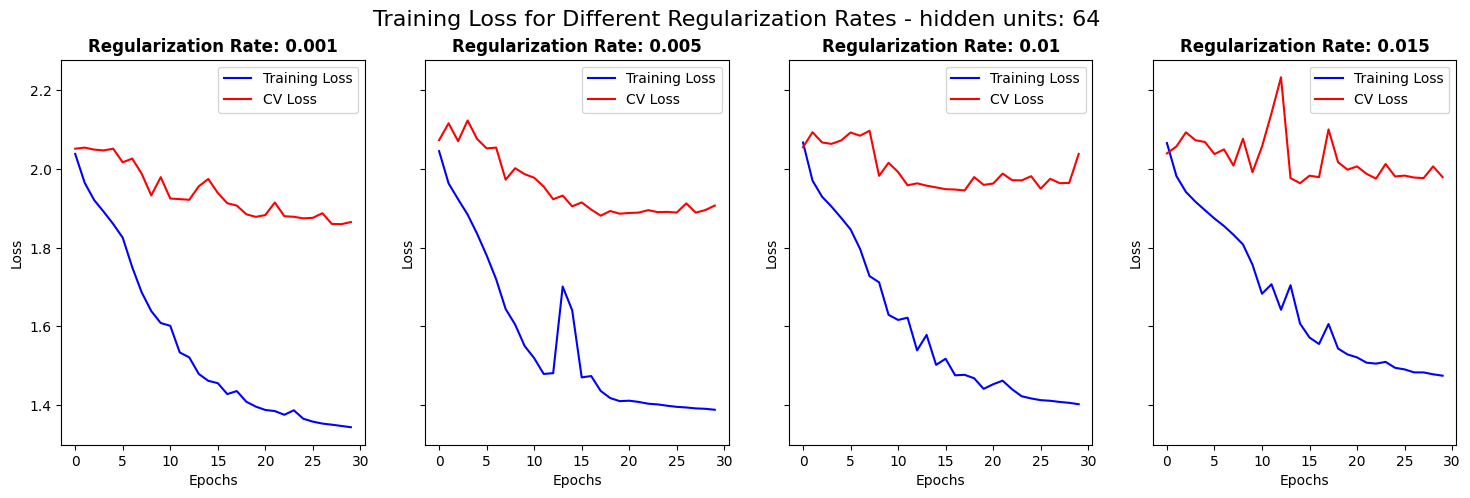

In [151]:
fig, ax = plt.subplots(row, column, figsize=(18, 5), sharey=True)
fig.suptitle('Training Loss for Different Regularization Rates - hidden units: 64', fontsize=16)

for i in range(column):
      ax[i].plot(train_losses_container_reg[i], label='Training Loss', color='b')
      ax[i].plot(cv_losses_container_reg[i], label='CV Loss', color='r')
      ax[i].set_title(f'Regularization Rate: {reg_rates[i]}', fontsize=12, fontweight='bold')
      ax[i].set_xlabel('Epochs')
      ax[i].set_ylabel('Loss')
      ax[i].legend()


plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()